In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from torch.optim.lr_scheduler import StepLR
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selectio

In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [4]:
np.random.seed(99)
torch.manual_seed(99)
torch.cuda.manual_seed(99)

### Load data

In [5]:
data = pd.read_table(
    "/home/bakirillov/HDD/data/Svetlana_data/Table_S8_machine_learning_input.txt", index_col=0
)

In [6]:
series = data['perfect match sgRNA']

In [7]:
print('series:', series.shape)

series: (26248,)


In [8]:
val_series = np.random.choice(np.unique(series), size=int(len(np.unique(series))*.20), replace=False)
val_indices = np.where(np.isin(series, val_series))
train_indices = np.where(~np.isin(series, val_series))

In [9]:
"GTGAGGCGAGGCGGTGAGTG"
"GTGAGGCGAGGCGGTGAGTGTGGC"

'GTGAGGCGAGGCGGTGAGTGTGGC'

In [10]:
data["sgRNA sequence"].head()

AAR2_-_34824434.23-P1P2_01    GTGAGGCGAGGCGGTGAGTG
AAR2_-_34824434.23-P1P2_02    GTGGGACGAGGCGGTGAGTG
AAR2_-_34824434.23-P1P2_03    GTGGGGGGAGGCGGTGAGTG
AAR2_-_34824434.23-P1P2_04    GTGGGGCGAAGCGGTGAGTG
AAR2_-_34824434.23-P1P2_05    GTGGGGCGACGCGGTGAGTG
Name: sgRNA sequence, dtype: object

In [11]:
data["sgRNA input"].head()

AAR2_-_34824434.23-P1P2_01    ACGTGAGGCGAGGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_02    ACGTGGGACGAGGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_03    ACGTGGGGGGAGGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_04    ACGTGGGGCGAAGCGGTGAGTGTGGC
AAR2_-_34824434.23-P1P2_05    ACGTGGGGCGACGCGGTGAGTGTGGC
Name: sgRNA input, dtype: object

In [12]:
data["sgRNA input"][0]

'ACGTGAGGCGAGGCGGTGAGTGTGGC'

In [13]:
data["genome input"][0]

'ACGTGGGGCGAGGCGGTGAGTGTGGC'

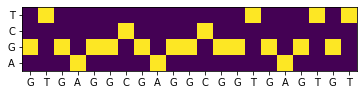

In [14]:
plt.imshow(correct_order(onehot('GTGAGGCGAGGCGGTGAGTGT')).reshape(4,21))
plt.xticks(np.arange(21), "GTGAGGCGAGGCGGTGAGTGT")
plt.yticks(np.arange(4), "AGCT")
plt.ylim((-0.5,3.5))
plt.show()

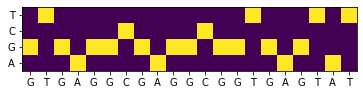

In [15]:
plt.imshow(correct_order(onehot("GTGAGGCGAGGCGGTGAGTAT")).reshape(4,21))
plt.xticks(np.arange(21), "GTGAGGCGAGGCGGTGAGTAT")
plt.yticks(np.arange(4), "AGCT")
plt.ylim((-0.5,3.5))
plt.show()

In [16]:
u = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=2, cut_at_end=1)

In [17]:
transformer = transforms.Compose(
    [
        u, ToTensor(cudap=True)
    ]
)

In [18]:
len(data["sgRNA input"][0])

26

In [19]:
train_set = WeissmanDataset(data, train_indices, transformer)
val_set = WeissmanDataset(data, val_indices, transformer, n_bins=0)

/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/core.py:883: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.S[self.label_column] = self.S[self.label_column] + np.abs(np.min(self.S[self.label_column]))
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/core.py:884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.S[self.label_column] = self.S[self.label_column].values/np.max(self.S[self.label_column])


In [20]:
train_set_loader = DataLoader(train_set, shuffle=True, batch_size=256)
val_set_loader = DataLoader(val_set, shuffle=True, batch_size=256)

In [21]:
EPOCHS = 30

In [22]:
print('X train:', len(train_set))
print('X validation:', len(val_set))

X train: 21007
X validation: 5241


### Model definition

In [23]:
encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
model = DKL(encoder, [1,5*32]).cuda().eval()

In [24]:
optimizer = Adam([
    {'params': model.parameters()}
], lr=0.01)
mll = DeepApproximateMLL(VariationalELBOEmpirical(model.likelihood, model, 256))

In [25]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [26]:
training, validation = model.fit(
    train_set_loader, val_set_loader, EPOCHS, scheduler, optimizer, mll, "Weissman.ptch"
)

1it [00:00,  5.78it/s]

Training, epoch #0, 83


83it [00:12,  6.53it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.18it/s]

Training statistics: 0.956025881859229; 0.028222037132367785 (11321,)
Validation, epoch #0, 21


21it [00:02,  7.40it/s]
1it [00:00,  6.08it/s]

Validation statistics: 0.48260185; 0.027501898 (5199,) 0.00016011934789505325
Training, epoch #1, 83


83it [00:12,  6.39it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.17it/s]

Training statistics: 0.2156603136978744; 0.022544732222656055 (20872,)
Validation, epoch #1, 21


21it [00:02,  7.51it/s]
1it [00:00,  6.29it/s]

Validation statistics: 0.010701778; 0.027311573 (5185,) 0.0014908479853007102
Training, epoch #2, 83


83it [00:12,  6.47it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.14it/s]

Training statistics: -0.17284273466958056; 0.021739691587490756 (20926,)
Validation, epoch #2, 21


21it [00:02,  7.35it/s]
1it [00:00,  6.10it/s]

Validation statistics: -0.27507827; 0.024291595 (5239,) 0.12420078515635045
Training, epoch #3, 83


83it [00:12,  6.45it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.17it/s]

Training statistics: -0.40937459700593953; 0.01959736912403163 (20973,)
Validation, epoch #3, 21


21it [00:02,  7.54it/s]
1it [00:00,  5.30it/s]

Validation statistics: -0.38301545; 0.02414729 (5239,) 0.13663582531966775
Training, epoch #4, 83


83it [00:12,  6.43it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.15it/s]

Training statistics: -0.578588839185256; 0.015494253630295522 (20983,)
Validation, epoch #4, 21


21it [00:02,  7.54it/s]
1it [00:00,  6.38it/s]

Validation statistics: -0.49364844; 0.018952945 (5237,) 0.37609425450448525
Training, epoch #5, 83


83it [00:13,  6.38it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.17it/s]

Training statistics: -0.7451514945750074; 0.011314543591285111 (20997,)
Validation, epoch #5, 21


21it [00:02,  7.47it/s]
1it [00:00,  5.30it/s]

Validation statistics: -0.21339682; 0.024932442 (5239,) 0.4223951968864599
Training, epoch #6, 83


83it [00:13,  6.38it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.03it/s]

Training statistics: -0.810007437435718; 0.0102276147665531 (20986,)
Validation, epoch #6, 21


21it [00:02,  7.36it/s]
1it [00:00,  6.22it/s]

Validation statistics: -0.6418439; 0.013851312 (5240,) 0.5081364032114085
Training, epoch #7, 83


83it [00:12,  6.47it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.18it/s]

Training statistics: -0.8251223930566511; 0.009943513350008319 (20991,)
Validation, epoch #7, 21


21it [00:02,  7.64it/s]
1it [00:00,  5.48it/s]

Validation statistics: -0.64309645; 0.013620742 (5240,) 0.5485520735646019
Training, epoch #8, 83


83it [00:12,  6.50it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.24it/s]

Training statistics: -0.8541611918295495; 0.009388476663129497 (20984,)
Validation, epoch #8, 21


21it [00:02,  7.12it/s]
1it [00:00,  6.12it/s]

Validation statistics: -0.663223; 0.012932067 (5233,) 0.572814044330475
Training, epoch #9, 83


83it [00:12,  6.42it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  6.85it/s]

Training statistics: -0.8605877106842743; 0.009342809391258568 (20992,)
Validation, epoch #9, 21


21it [00:02,  7.30it/s]
1it [00:00,  5.51it/s]

Validation statistics: -0.64340854; 0.013579979 (5236,) 0.5509997571230235
Training, epoch #10, 83


83it [00:13,  6.32it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  6.86it/s]

Training statistics: -0.9015297812729598; 0.00856640803619646 (20972,)
Validation, epoch #10, 21


21it [00:02,  7.10it/s]
1it [00:00,  5.11it/s]

Validation statistics: -0.78897095; 0.010651327 (5238,) 0.616150179562434
Training, epoch #11, 83


83it [00:12,  6.51it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.38it/s]

Training statistics: -0.9159926530747144; 0.00826601260094037 (20971,)
Validation, epoch #11, 21


21it [00:02,  7.68it/s]
1it [00:00,  6.38it/s]

Validation statistics: -0.79886216; 0.010493822 (5240,) 0.6219074715843453
Training, epoch #12, 83


83it [00:12,  6.44it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.08it/s]

Training statistics: -0.9209641130918774; 0.008202011176368264 (20975,)
Validation, epoch #12, 21


21it [00:02,  7.66it/s]
1it [00:00,  5.83it/s]

Validation statistics: -0.78497225; 0.010670464 (5240,) 0.6204996132729238
Training, epoch #13, 83


83it [00:12,  6.45it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.19it/s]

Training statistics: -0.9221195504674757; 0.00816908290542329 (20975,)
Validation, epoch #13, 21


21it [00:02,  7.21it/s]
1it [00:00,  6.08it/s]

Validation statistics: -0.7859161; 0.0106656505 (5238,) 0.6207542341482404
Training, epoch #14, 83


83it [00:12,  6.40it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.08it/s]

Training statistics: -0.91728509656893; 0.008149290872140552 (20972,)
Validation, epoch #14, 21


21it [00:02,  7.42it/s]
1it [00:00,  6.45it/s]

Validation statistics: -0.77879155; 0.0107312985 (5240,) 0.6201662874885625
Training, epoch #15, 83


83it [00:13,  6.38it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.06it/s]

Training statistics: -0.9295971911007286; 0.0081066128977533 (20968,)
Validation, epoch #15, 21


21it [00:02,  7.42it/s]
1it [00:00,  6.33it/s]

Validation statistics: -0.77529716; 0.010788048 (5239,) 0.6192778126637172
Training, epoch #16, 83


83it [00:12,  6.40it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  6.78it/s]

Training statistics: -0.9280938578784148; 0.008052488289038392 (20968,)
Validation, epoch #16, 21


21it [00:02,  7.36it/s]
1it [00:00,  6.30it/s]

Validation statistics: -0.7840746; 0.010548206 (5240,) 0.6195677525323849
Training, epoch #17, 83


83it [00:12,  6.39it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.25it/s]

Training statistics: -0.93077628452588; 0.00804616643993955 (20978,)
Validation, epoch #17, 21


21it [00:02,  7.59it/s]
1it [00:00,  6.40it/s]

Validation statistics: -0.7987744; 0.010417797 (5238,) 0.6245445894603928
Training, epoch #18, 83


83it [00:12,  6.44it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.15it/s]

Training statistics: -0.9367670497907098; 0.00798080438748638 (20969,)
Validation, epoch #18, 21


21it [00:02,  7.51it/s]
1it [00:00,  5.64it/s]

Validation statistics: -0.78893906; 0.010512538 (5236,) 0.6251298624914002
Training, epoch #19, 83


83it [00:12,  6.43it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.20it/s]

Training statistics: -0.926659148151407; 0.008010129948728325 (20986,)
Validation, epoch #19, 21


21it [00:02,  7.49it/s]
1it [00:00,  6.35it/s]

Validation statistics: -0.7783618; 0.010549394 (5238,) 0.6215791162886711
Training, epoch #20, 83


83it [00:12,  6.43it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.07it/s]

Training statistics: -0.9435537962548789; 0.007875173492913702 (20964,)
Validation, epoch #20, 21


21it [00:02,  7.48it/s]
1it [00:00,  5.32it/s]

Validation statistics: -0.7934275; 0.010423912 (5238,) 0.6250511490046026
Training, epoch #21, 83


83it [00:12,  6.39it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.31it/s]

Training statistics: -0.9459855565137003; 0.007851077114970559 (20959,)
Validation, epoch #21, 21


21it [00:02,  7.40it/s]
1it [00:00,  6.47it/s]

Validation statistics: -0.7965018; 0.010373073 (5236,) 0.6250280939175904
Training, epoch #22, 83


83it [00:12,  6.44it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.20it/s]

Training statistics: -0.9444000339871688; 0.007803120342931343 (20958,)
Validation, epoch #22, 21


21it [00:02,  7.35it/s]
1it [00:00,  5.22it/s]

Validation statistics: -0.79283875; 0.010399212 (5237,) 0.6247779295007608
Training, epoch #23, 83


83it [00:13,  6.04it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  6.93it/s]

Training statistics: -0.9470760306723721; 0.007833674762499564 (20962,)
Validation, epoch #23, 21


21it [00:02,  7.11it/s]
1it [00:00,  5.09it/s]

Validation statistics: -0.79659986; 0.010350049 (5239,) 0.6251596665023057
Training, epoch #24, 83


83it [00:13,  6.10it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.29it/s]

Training statistics: -0.9460781020324964; 0.007795953634624517 (20970,)
Validation, epoch #24, 21


21it [00:02,  7.53it/s]
1it [00:00,  5.30it/s]

Validation statistics: -0.7902832; 0.010439255 (5239,) 0.6255564952276578
Training, epoch #25, 83


83it [00:12,  6.46it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.25it/s]

Training statistics: -0.9419030846007379; 0.007841771200898745 (20951,)
Validation, epoch #25, 21


21it [00:02,  7.84it/s]
1it [00:00,  5.38it/s]

Validation statistics: -0.78626204; 0.010403837 (5238,) 0.6255156201683899
Training, epoch #26, 83


83it [00:13,  6.31it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.06it/s]

Training statistics: -0.9501289113934146; 0.007774915457582369 (20966,)
Validation, epoch #26, 21


21it [00:02,  7.64it/s]
1it [00:00,  6.50it/s]

Validation statistics: -0.79572856; 0.010375125 (5239,) 0.6250769207658725
Training, epoch #27, 83


83it [00:12,  6.52it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.42it/s]

Training statistics: -0.9441333620157253; 0.00778754146005223 (20961,)
Validation, epoch #27, 21


21it [00:02,  7.13it/s]
1it [00:00,  5.59it/s]

Validation statistics: -0.78997976; 0.010377421 (5240,) 0.6255711014755555
Training, epoch #28, 83


83it [00:13,  6.16it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  6.71it/s]

Training statistics: -0.9505655265699091; 0.0077786717870842225 (20967,)
Validation, epoch #28, 21


21it [00:03,  6.85it/s]
1it [00:00,  5.93it/s]

Validation statistics: -0.7879254; 0.010401054 (5240,) 0.6254523756546938
Training, epoch #29, 83


83it [00:13,  6.30it/s]
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bakirillov/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00,  7.45it/s]

Training statistics: -0.94723308404651; 0.007794289501517262 (20966,)
Validation, epoch #29, 21


21it [00:02,  7.53it/s]

Validation statistics: -0.7897434; 0.010396927 (5239,) 0.6258054705886135


In [63]:
y_hat = []
y = []
y_hat_std = []
for i,b in tqdm(enumerate(val_set)):
    sequence, target = b
    y.append(target)
    ss = sequence.shape
    output, _ = model.forward(sequence.reshape(1, *ss))
    predictions = model.likelihood(output).mean.mean(0).cpu().data.numpy()
    y_hat_std.append(model.likelihood(output).variance.mean(0).cpu().data.numpy()[0]**0.5)
    y_hat.append(predictions[0])

5241it [00:56, 92.16it/s]


In [64]:
y_hat_std

[0.09300936264643218,
 0.09268834076202342,
 0.0928575385517228,
 0.09267185070196389,
 0.09276491427169385,
 0.09255758572746144,
 0.0925821641451308,
 0.09261720452213976,
 0.09257465448594471,
 0.09270902204347031,
 0.09257775298579031,
 0.0925021723140991,
 0.09308949891519909,
 0.09312535847524478,
 0.09284835099735476,
 0.09305950531486847,
 0.09262516822362082,
 0.09260913454278474,
 0.09257081139724896,
 0.0925321100456544,
 0.09258383902287316,
 0.09256007102983571,
 0.09264774340552852,
 0.09259794602492588,
 0.09259690001797882,
 0.09252268382574536,
 0.09304547830105117,
 0.0927003974500436,
 0.09282850839490427,
 0.09259262534754668,
 0.09258198810516996,
 0.09259235880273647,
 0.09253015744254488,
 0.09255414946061527,
 0.09273097421698054,
 0.09274501867201013,
 0.09264617020779002,
 0.09352425874804077,
 0.09272092035477177,
 0.09985416850503821,
 0.10990415872282241,
 0.11226940015287003,
 0.09378412241637804,
 0.0927945113088981,
 0.09256969968869969,
 0.0927960167562

In [57]:
target

0.4462453690721714

In [47]:
model.likelihood(output).variance.mean()

tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>)

In [41]:
a, b = model.likelihood(output).confidence_region()

In [44]:
a.mean(), b.mean()

(tensor(-0.0585, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3158, device='cuda:0', grad_fn=<MeanBackward0>))

In [46]:
model.likelihood(output).mean.mean()

tensor(0.1287, device='cuda:0', grad_fn=<MeanBackward0>)

In [51]:
model.likelihood(output).mean.mean()+2*model.likelihood(output).variance.mean()**0.5

tensor(0.3158, device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
y_hat = np.stack(y_hat).squeeze()

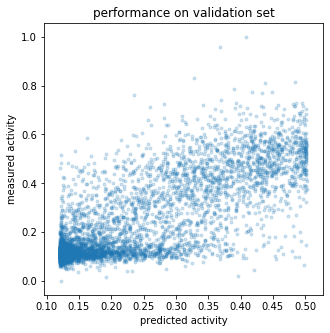

In [29]:
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(y_hat, y, marker='.', alpha=.2)
ax.set_xlabel('predicted activity')
ax.set_ylabel('measured activity')
ax.set_title('performance on validation set');

In [30]:
y_hat.ravel()

array([0.44681987, 0.30878615, 0.40462705, ..., 0.12672198, 0.12144233,
       0.12856534], dtype=float32)

In [31]:
print('r squared = %.3f'%pearsonr(y, y_hat.ravel())[0]**2)

r squared = 0.626
